In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, lax, device_get, vmap
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy.stats import norm
from jax.scipy.special import gamma
import pickle
from functools import partial
import math

import numpy as np
from Discrete_RDP_Mechanism import DiscreteRDPPrivacyLoss, from_discrete_RDP_mechanism
from dp_accounting.pld.privacy_loss_distribution import from_gaussian_mechanism
# Set precision to float64
jax.config.update("jax_enable_x64", True)
# Set print precision
jnp.set_printoptions(precision=18)

# RDP Code

In [2]:
'''
noise parameters: p_vec=[p_0 ... p_N]
I assume that the noise distribution is symmetric so p[j]=p[-j]
noise_parameter function outputs the pdf values:p_i=p_vec[|i|] for -N<= i<=N and p_i=p_vec[N] r**{|i|-N} for |i|>N
'''
@jit
def noise_parameter(j, p_vec, r, N):
    condition = (j >= -N) & (j <= N)
    result = jnp.where(condition, p_vec[jnp.abs(j)], p_vec[N] * jnp.power(r,jnp.abs(j)-N))
    return result
########### Initialization ###################
# Use Gaussian_Like_Distribution in the high cost regime and Laplace_Like_Distribution in the low cost regime
def Gaussian_Like_Distribution(C, k, N, r):
    indices = jnp.arange(N+1)
    cdf_values = jax.scipy.stats.norm.cdf(-(2 * indices -1) / (2 * k * jnp.sqrt(C)))
    differences = -jnp.diff(cdf_values)
    differences = jnp.append(differences,cdf_values[-1])
    p_vector = jnp.where(indices == N, differences * k * (1 - r), k * differences)
    return p_vector
Gaussian_Like_Distribution= jit(Gaussian_Like_Distribution, static_argnums=(2,))

@jit
def laplace_cdf(x, b):
    return jnp.where(x >= 0, 1 - 0.5 * jnp.exp(-x / b), 0.5 * jnp.exp(x / b))
def Laplace_Like_Distribution(C, k, N, r):
  indices = jnp.arange(N+1)
  b=jnp.sqrt(C/2)
  cdf_values = laplace_cdf(-(2 * indices -1) / (2 * k),b)
  differences = -jnp.diff(cdf_values)
  differences = jnp.append(differences,cdf_values[-1])
  p_vector = jnp.where(indices == N, differences * k * (1 - r), k * differences)
  return p_vector
Laplace_Like_Distribution= jit(Laplace_Like_Distribution, static_argnums=(2,))
################# Constraints and Projection ########
def Compute_Cost_Vector(k,q,r,N):
  def c_i(i,q,k):#for 1<=i<=N-1
    c_value=2/((q+1)*k**(q+1))*((i+0.5)**(q+1)-(i-0.5)**(q+1))
    return c_value
  def Compute_c_N(k,q,r,N,limit=1000):
    def compute_infinite_sum(q,r,N,limit):
      i_values = jnp.arange(N, limit)
      total_sum = jnp.sum(r**i_values * ((i_values + 0.5)**(q + 1) - (i_values - 0.5)**(q + 1)))
      return total_sum
    infinite_sum=compute_infinite_sum(q,r,N,limit)
    c_N=2*r**(-N)/((q+1)*k**(q+1))*infinite_sum
    return c_N
  c_0=2/(q+1)/(2*k)**(q+1)
  i_values = jnp.arange(1, N)
  c_values = c_i(i_values, q, k)
  c_N=Compute_c_N(k,q,r,N)
  c_vector = jnp.concatenate((jnp.array([c_0]), c_values, jnp.array([c_N])))
  return c_vector
Compute_Cost_Vector= jit(Compute_Cost_Vector, static_argnums=(3,))

def Normalization_Constraint(N,k,r):
  vector = 1/k*jnp.concatenate((jnp.array([1]), 2 * jnp.ones(N-1), jnp.array([2 / (1 - r)])))
  return vector
Normalization_Constraint = jit(Normalization_Constraint, static_argnums=(0,1))


def Constraints_matrix(N,k,r,q):
  cost_vec=Compute_Cost_Vector(k,q,r,N)
  normalization_vec=Normalization_Constraint(N,k,r)
  A = jnp.vstack([cost_vec, normalization_vec])
  return A
Constraints_matrix= jit(Constraints_matrix, static_argnums=(0,1))
'''
The following function projects onto the space satisfying cost and normalization constraints
Compute tilde_g = g - A^T (A^T A)^(-1) A g
'''
@jit
def projected_gradient_func(A, g):
    AAT = jnp.dot(A, A.T)
    AAT_inv = jnp.linalg.inv(AAT)
    term = jnp.dot(A.T, jnp.dot(AAT_inv, A))
    tilde_g = g - jnp.dot(term, g)
    return tilde_g

@jit
def impose_positivity(noise,projected_gradient,scale):
  def min_ratio(p, G):
    mask = G > 0
    masked_ratios = jnp.where(mask, p / G, jnp.inf)
    min_ratios = jnp.min(masked_ratios, axis=0)
    return min_ratios
  noise_diag=jnp.diag(noise)
  productt=jnp.dot(noise_diag,projected_gradient)
  min_ratio=min_ratio(noise, productt)
  noise_learning_rate_upper=jnp.minimum(min_ratio/scale,100000)
  return noise_learning_rate_upper

def check_constraints(noise,N,k,r,q): #cost and normalization constraints
  c_vec=Compute_Cost_Vector(k,q,r,N)
  normaliztion_vec=Normalization_Constraint(N,k,r)
  Cost=jnp.dot(c_vec,noise)
  normalization_constant=jnp.dot(noise,normaliztion_vec)
  return Cost,normalization_constant
check_constraints= jit(check_constraints, static_argnums=(1,2))

def check_positivity_constraint(vector, error_message="Vector contains non-positive elements."):
    if jnp.any(vector <= 0):
        raise ValueError(error_message)
########## Worst-case shift algorithm ########
def term3_func(p_vec,N,k,r,alpha):
  indices = jnp.arange(-k-N,-N)
  r_power = jnp.power(r, -indices * (1 - alpha)) #r_power[-t-N:-N]r_power[k-t:k]
  return r_power
term3_func= jit(term3_func, static_argnums=( 1,2,3,4))

def term2_func(p_vec,N,k,r,alpha):
  p=jnp.power(jnp.concatenate([p_vec[::-1][:-1], p_vec]), 1 - alpha) #keep it
  return p
term2_func = jit(term2_func, static_argnums=(1,2,3,4))

def p_shifted_raised_to_alpha(p_vec,N,k,r,alpha):
  indices = jnp.arange(-N,N+k+1)
  p_t_shifted= vmap(lambda j: noise_parameter(j, p_vec, r, N))(indices)
  p_shifted_raised_to_alpha_power = jnp.power(p_t_shifted, alpha)
  return p_shifted_raised_to_alpha_power
p_shifted_raised_to_alpha = jit(p_shifted_raised_to_alpha, static_argnums=(1,2,3,4))

def term1_func_t(t,p_vec,N,k,r,alpha):
  term1 = 1/k*(p_vec[N] * r / (1 - r) * (r**((1 - alpha) * t) + r**(alpha * t)))
  return term1
term1_func_t=jit(term1_func_t,static_argnums=(0,2,3))

def term2_func_t(t,p,p_shifted_raised_to_alpha_power,N,k):
  result=1/k*jnp.dot(p_shifted_raised_to_alpha_power[t:(2*N+t+1)],p)
  return result
term2_func_t=jit(term2_func_t,static_argnums=(0,3,4))

def term3_func_t(p_vec,p_shifted_raised_to_alpha_power,r_power,t,N,k,r,alpha):
  result=1/k*jnp.power(p_vec[N] * r**(-N), 1 - alpha)*jnp.dot(p_shifted_raised_to_alpha_power[0:t],r_power[k-t:k])
  return result
term3_func_t=jit(term3_func_t,static_argnums=(3,4,5))

def Renyi_term_t(t,p_vec,p2,p_shifted_raised_to_alpha_power,r_power3,N,k,r,alpha):
  Renyi_term=1/(alpha-1)*jnp.log(term1_func_t(t,p_vec,N,k,r,alpha)
                    +term2_func_t(t,p2,p_shifted_raised_to_alpha_power,N,k)
                    +term3_func_t(p_vec,p_shifted_raised_to_alpha_power,r_power3,t,N,k,r,alpha))
  return Renyi_term
Renyi_term_t=jit(Renyi_term_t,static_argnums=(0,5,6,7,8))

def worst_case_shift(p_vec,N,k,r,alpha):
  p_shifted_raised_to_alpha_power=p_shifted_raised_to_alpha(p_vec,N,k,r,alpha)
  p2=term2_func(p_vec,N,k,r,alpha)
  r_power3=term3_func(p_vec,N,k,r,alpha)
  Renyi_terms=jnp.zeros(k+1)
  for t in range(k + 1):
    Renyi_term = Renyi_term_t(t, p_vec, p2, p_shifted_raised_to_alpha_power, r_power3, N,k,r,alpha)
    Renyi_terms = Renyi_terms.at[t].set(Renyi_term)
  Renyi_max = jnp.max(Renyi_terms)
  t = jnp.arange(0,k+1)/k
  optimal_endpoint = t[jnp.argmax(Renyi_terms)]
  return optimal_endpoint,Renyi_max

worst_case_shift=jit(worst_case_shift,static_argnums=(1,2))
########### Objective and its Gradient ###############
def objective(noise,N,k,r,alpha):
    _, obj_value = worst_case_shift(noise,N,k,r,alpha)
    main_objective=obj_value
    return main_objective
objective = jit(objective, static_argnums=(1,2,3,4))

grad_objective= jit(grad(objective, argnums=0), static_argnums=(1, 2,3,4))

############ Backtracking line search #########
def backtracking_line_search(x, gradient, t, factor,step,N,k,r,alpha,power_num):
  def calculate_learning_rate(t, factor, power):
    return t * factor ** power
  z=jnp.ones(N+1)
  power_range=jnp.arange(power_num)
  power_range = jnp.where(step >= 2000, power_range + 2, jnp.where(step >= 1000, power_range + 1, power_range))
  learning_rates = vmap(lambda power: calculate_learning_rate(t, factor, power))(power_range)
  new_objective = vmap(lambda lr: objective(jnp.dot(jnp.diag(x),z - lr * gradient),N,k,r,alpha))(learning_rates)
  best_objective = jnp.min(new_objective)
  min_index = jnp.argmin(new_objective)
  best_learning_rate = learning_rates[min_index]
  best_new_z=z - best_learning_rate * gradient
  best_new_x=jnp.dot(jnp.diag(x),best_new_z)
  return best_learning_rate,best_new_x,best_objective
backtracking_line_search= jit(backtracking_line_search, static_argnums=(5,6,7,8,9))
##################### Gradient Descent #############
def gradient_descent(init_noise,num_steps,scale,factor,power_num,N,k,r,alpha,q):
  objectives=jnp.zeros(num_steps+1)
  initial_objective=objective(init_noise,N,k,r,alpha)
  print('initial objective:',initial_objective)
  objectives=objectives.at[0].set(initial_objective)
  noise= init_noise
  A=Constraints_matrix(N,k,r,q)
  print_interval = 10000
  for step in tqdm(range(num_steps)):
    z=jnp.ones(N+1)
    gradient = grad_objective(noise,N,k,r,alpha)
    gradient_new=jnp.dot(jnp.diag(noise),gradient)
    A_new=jnp.dot(A,jnp.diag(noise))
    projected_gradient=projected_gradient_func(A_new, gradient_new)
    noise_learning_rate_upper_bound=impose_positivity(noise,projected_gradient,scale)
    noise_learning_rate,noise,new_objective=backtracking_line_search(noise,projected_gradient,noise_learning_rate_upper_bound, factor,step,N,k,r,alpha,power_num)
    check_positivity_constraint(noise)
    intermediate_objective = new_objective
    objectives=objectives.at[step+1].set(intermediate_objective)
    if step % print_interval == 0:
      Cost,normalization_constant=check_constraints(init_noise,N,k,r,q)
      print(f"cost:{Cost}, normalization_constant:{normalization_constant}")
      norm_projected_gradient = jnp.linalg.norm(projected_gradient, ord=jnp.inf)
      print(f"step:{step}, intermediate_objective:{intermediate_objective},norm_projected_gradient: {norm_projected_gradient},noise_learning_rate:{noise_learning_rate}")
  final_objective = objective(noise,N,k,r,alpha)
  return noise,objectives
####### Gaussian's moments ############
def t_th_central_absolute_moment_of_Gaussian(sigma,t):#mu=0
  result=(sigma**t)*(2**(t/2))*gamma((t+1)/2)/jnp.sqrt(jnp.pi)
  return result
def Gaussian_variance_from_qth_absolute_moment(absolute_moment, q):
  Gaussian_var=0.5*(jnp.sqrt(jnp.pi)*absolute_moment/gamma((q+1)/2))**(2/q)
  return Gaussian_var
####################### Plots #########################
'''
The indicator function is true if z\in((i-1/2)/k,(i+1/2)/k) or z\in(-(i+1/2)/k,-(i-1/2)/k).
'''
def indicator_function(z, i, k):
  l = (i - 0.5) / k
  u = (i + 0.5) / k
  return jnp.logical_and(z > -u, z < -l) + jnp.logical_and(z > l, z < u)

def noise_distribution(z, N, k,r,p_vec):
  def weighted_indicator_sum(i):
      return p_vec[i] * indicator_function(z, i, k)
  j_values = jnp.arange(3*N + 1)
  p_vec=noise_parameter(j_values, p_vec, r, N)
  return jax.vmap(weighted_indicator_sum)(jnp.arange(0,3*N + 1)).sum(axis=0)

noise_distribution= jit(noise_distribution, static_argnums=(1,))
def draw_objective(objectives,N,k,r,alpha):
  plt.figure()
  plt.plot(range(len(objectives)),objectives)
  plt.xlabel('iteration')
  plt.ylabel(' Renyi DP')
  plt.title(f'k={k},N={N},r={r},alpha={alpha}')
  plt.savefig(f'Objective_k={k},N={N},r={r},alpha={alpha}.png')
  plt.show()


def plot_distribution(p_vec, N, k, r,cost, Gaussian_var=None, lim=None, lim_L=None, num_points=10000, noise_label='Optimal noise'):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    Gaussian_mean=0
    x_values = jnp.linspace(-3 * N / k - 1, 3 * N / k + 1, num_points)
    noise_pdf = noise_distribution(x_values, N, k, r, p_vec)
    axs[0].plot(x_values, noise_pdf, label=noise_label)
    axs[0].set(xlabel='z', ylabel='Probability Density')
    if lim is not None:
      axs[0].set_xlim(-lim, lim)
    if  Gaussian_var is not None:# Compare with Gaussian plots
        std_dev = jnp.sqrt(Gaussian_var)
        pdf_vals = norm.pdf(x_values, loc=Gaussian_mean, scale=std_dev)
        axs[0].plot(x_values, pdf_vals, label=f'Gaussian: var {Gaussian_var:.3f}')
        axs[1].semilogy(x_values, pdf_vals, label=f'Gaussian: var {Gaussian_var:.3f}')
    axs[1].semilogy(x_values, noise_pdf, label=noise_label)
    axs[1].set(xlabel='z', ylabel='Probability Density')
    axs[1].set_ylim(1e-15, None)
    if lim_L is not None:
      axs[1].set_xlim(-lim_L, lim_L)
    for ax in axs:
        ax.legend(loc='upper left')
        ax.grid(True)
    caption_text = f'N={N}, k={k}, Cost={cost:.3f}'
    plt.text(1.1, 0.5, caption_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round", alpha=0.1))
    plt.show()

###### Save and Load the results ##############
def save_vector(noise_parameters, k, N, r, cost, q,alpha, Our_RD, Gaussian_RD):
    Our_RD_str = format(Our_RD, '.22f')
    Gaussian_RD_str = format(Gaussian_RD, '.22f')
    filename = f"noise_k{k}_N{N}_r{r}_cost{cost}_q{q}_alpha{alpha}.pkl"
    parameters = {
        "noise_parameters": noise_parameters,
        "Our_RD": Our_RD_str,
        "Gaussian_RD": Gaussian_RD_str
    }
    with open(filename, 'wb') as f:
        pickle.dump(parameters, f)

def load_vector(filename):
    with open(filename, 'rb') as f:
        loaded_vector = pickle.load(f)
    return loaded_vector

def get_noise_parameters_as_vector(loaded_parameters):
    noise_parameters = loaded_parameters["noise_parameters"]
    if isinstance(noise_parameters, list):
        noise_parameters = jnp.array(noise_parameters)
    return noise_parameters


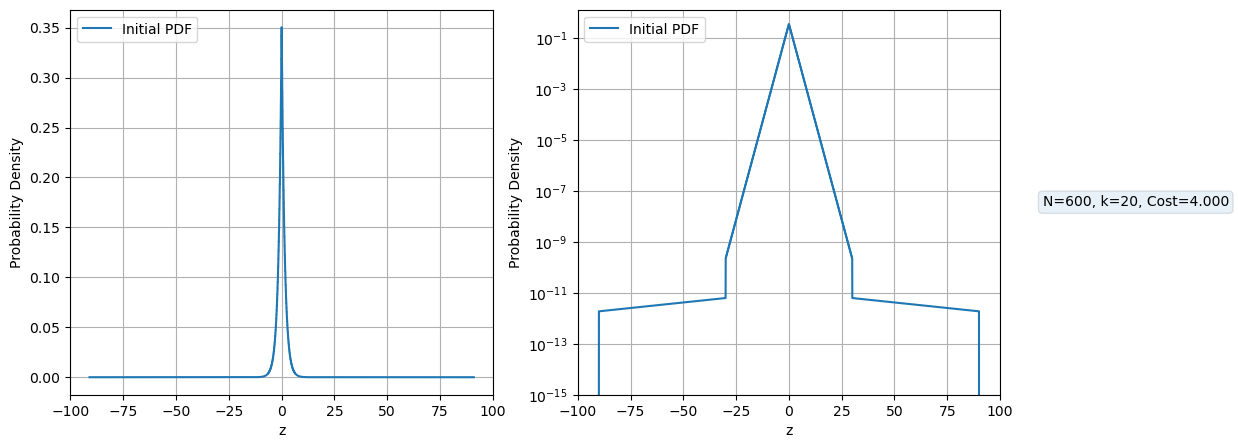

  Initial Cost is 3.999770483326583, and  Initial normalization_constant is 1.000000000000001


In [3]:
# Specify the hyperparameter values
q=2
C=(2)**2-0.00064587
r=0.999 # r\in (0,1) is the common ratio of the tail of P_Z
k=20 #1/k is the resolution of the distribution; k>1/sqrt(12C)
N=600 # number of bins
alpha=10
Gaussian_var=Gaussian_variance_from_qth_absolute_moment(C,q)
N_lower=3*k*jnp.sqrt(Gaussian_var)
# Gaussian_Like= Gaussian_Like_Distribution(Gaussian_var, k, N, r)
Gaussian_Like= Laplace_Like_Distribution(C, k, N, r)
check_positivity_constraint(Gaussian_Like)
Init_Cost,Init_normalization_constant=check_constraints(Gaussian_Like,N,k,r,q)
Gaussian_var=Gaussian_variance_from_qth_absolute_moment(Init_Cost,q)
plot_distribution(Gaussian_Like, N, k, r, Gaussian_var=None, cost=Init_Cost, lim=None, lim_L=None, num_points=10000, noise_label='Initial PDF')
print("\033[95m  Initial Cost is {}\033[0m, and \033[95m Initial normalization_constant is {}\033[0m".format(Init_Cost, Init_normalization_constant))


/n/home10/jfgomez/.conda/envs/atefeh-renyi-dp/lib/python3.10/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/n/home10/jfgomez/.conda/envs/atefeh-renyi-dp/lib/python3.10/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/n/home10/jfgomez/.conda/envs/atefeh-renyi-dp/lib/python3.10/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/n/home10/jfgomez/.conda/envs/atefeh-renyi-dp/lib/python3.10/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._

initial objective: 1.6649323878623943


  0%|          | 19/20000 [00:02<33:43,  9.87it/s]  

cost:3.999770483326583, normalization_constant:1.000000000000001
step:0, intermediate_objective:0.6701815283738323,norm_projected_gradient: 0.99990509229795,noise_learning_rate:1.5424208605839402


 50%|█████     | 10027/20000 [00:55<00:53, 187.99it/s]

cost:3.999770483326583, normalization_constant:1.000000000000001
step:10000, intermediate_objective:0.5929933718344681,norm_projected_gradient: 0.07002056669173365,noise_learning_rate:0.004103134430920703


100%|██████████| 20000/20000 [01:48<00:00, 184.13it/s]


Optimal noise distribution: Array([3.4137777946316056e-01, 3.3551637874023410e-01,
       3.2192104446422137e-01, 3.1574953370604486e-01,
       3.1083412887658435e-01, 2.9972596284644876e-01,
       2.8014684548518659e-01, 2.5306957300372812e-01,
       2.2685912468203237e-01, 1.9723280655085501e-01,
       1.6610949931819693e-01, 1.5940945548417218e-01,
       1.6624472626398493e-01, 1.7591381675007073e-01,
       1.8806595147336236e-01, 1.9607038974795948e-01,
       1.9925947825187248e-01, 1.9906477328957939e-01,
       2.0011428950139673e-01, 2.0612883011733099e-01,
       2.0766268933382470e-01, 2.0227442142018290e-01,
       1.9236521027870854e-01, 1.8704148564626985e-01,
       1.8263155498198877e-01, 1.7476531501417675e-01,
       1.6216898654150733e-01, 1.4550067709184927e-01,
       1.2958823390713617e-01, 1.1200891585401766e-01,
       9.3981372128589702e-02, 8.9816968366389000e-02,
       9.3058159610275054e-02, 9.7812696551445935e-02,
       1.0390975472314973e-01, 1.0769

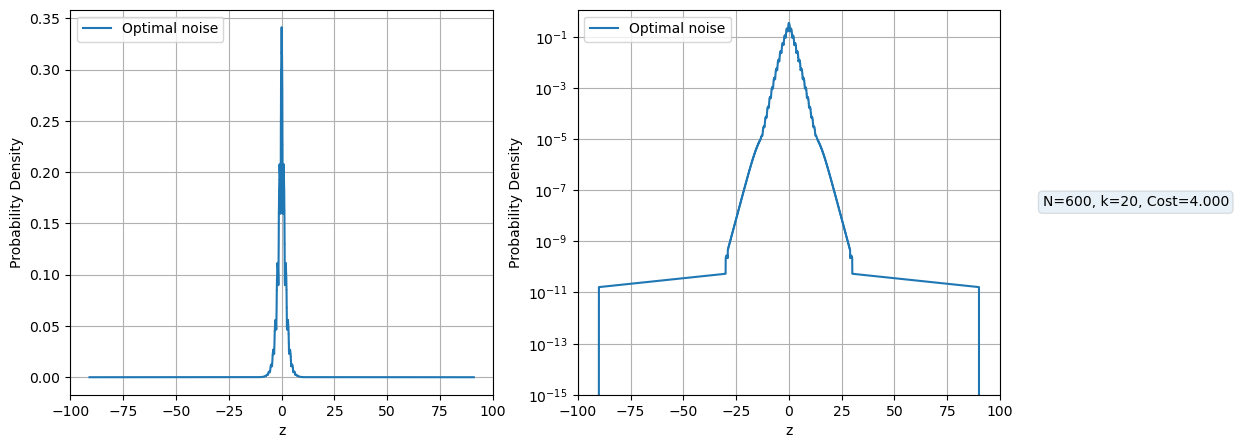

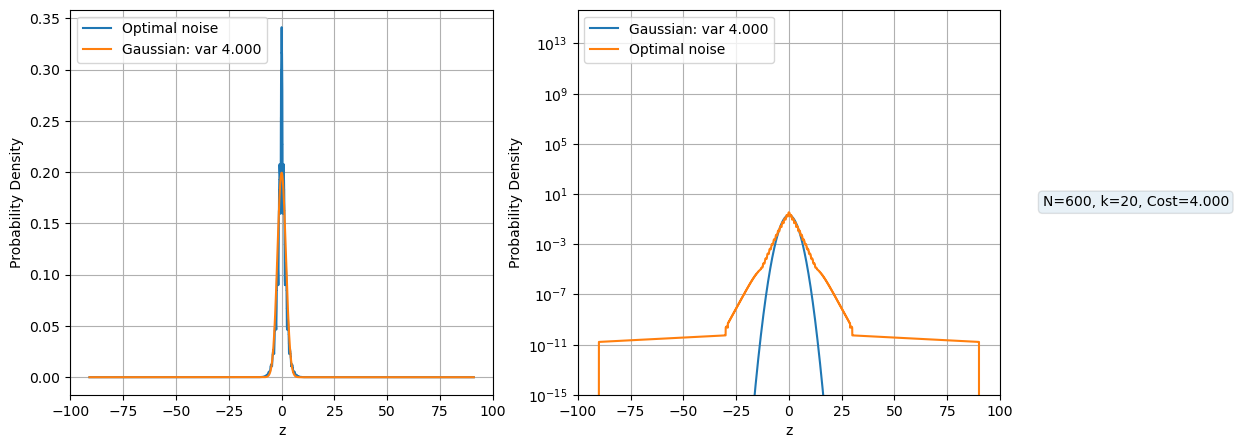

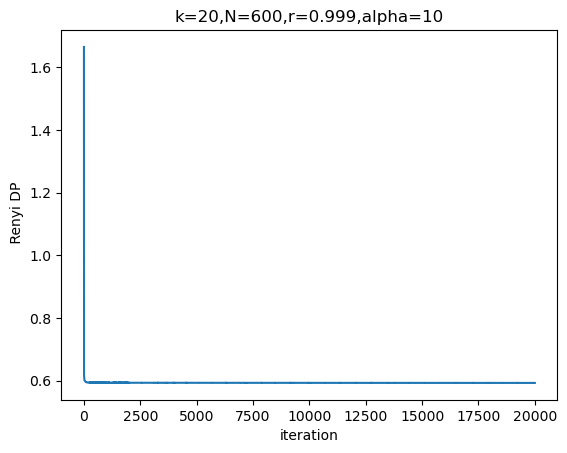

time: 110.1649420261383
  Initial Cost is 3.999770483326583, and  Initial normalization_constant is 1.000000000000001
  Final Cost is 3.9997704833269445, and  final normalization_constant is 1.000000000000292
Our objective is 0.5928059550021014, and Gaussian's objective is 1.2500717280760278 ¯\_(ツ)_/¯


In [4]:
start_time=time.time()
num_steps=20000
scale=2
factor=0.5
power_num=10
init_noise=Gaussian_Like
optimal_noise,objectives=gradient_descent(init_noise,num_steps,scale,factor,power_num,N,k,r,alpha,q)
Final_Cost,Final_normalization_constant=check_constraints(optimal_noise,N,k,r,q)
check_positivity_constraint(optimal_noise)
print('Optimal noise distribution:', repr(optimal_noise))
plot_distribution(optimal_noise, N, k, r, Gaussian_var=None, cost=Final_Cost, lim=None, lim_L=None, num_points=10000, noise_label='Optimal noise')
Gaussian_var=Gaussian_variance_from_qth_absolute_moment(Final_Cost,q)
plot_distribution(optimal_noise, N, k, r, Gaussian_var=Gaussian_var, cost=Final_Cost, lim=None, lim_L=None, num_points=10000, noise_label='Optimal noise')
draw_objective(objectives,N,k,r,alpha)
end_time=time.time()
print('time:',end_time-start_time)
#comparison of our objective with Gaussian's
print("\033[95m  Initial Cost is {}\033[0m, and \033[95m Initial normalization_constant is {}\033[0m".format(Init_Cost, Init_normalization_constant))
print("\033[95m  Final Cost is {}\033[0m, and \033[95m final normalization_constant is {}\033[0m".format(Final_Cost, Final_normalization_constant))
Gaussain_Renyi_divergence=alpha/(2*Gaussian_var)
if objectives[-1] < Gaussain_Renyi_divergence:
    print("\033[94mOur objective is {}\033[0m, and \033[94mGaussian's objective is {} ¯\_(ツ)_/¯\033[0m".format(objectives[-1], Gaussain_Renyi_divergence))
else:
    print("\033[94mOur objective is {}\033[0m, and \033[94mGaussian's objective is {} 🤷‍♀️\033[0m".format(objectives[-1], Gaussain_Renyi_divergence))



# Using PLD Accounting

In [56]:
compositions = 10
sigma_squared, _ = check_constraints(optimal_noise,N,k,r,q)
sigma = np.sqrt(float(sigma_squared))

# integer shift of s means shift of s / k
s = k 
epsy = np.linspace(-4,2,300)
epsy_composed = np.linspace(-1.1, 10, 100)

# get true privacy curve from closed form
deltas_true = DiscreteRDPPrivacyLoss(p_vec = optimal_noise, k = k, N = N, r = r, sensitivity = s).get_delta_for_epsilon(epsy)

# get pld's
pld = from_discrete_RDP_mechanism(p_vec = optimal_noise, k = k, N = N, r = r, sensitivity = s)
pld_gaussian = from_gaussian_mechanism(standard_deviation = sigma)

# get upper bound on privacy curve from pld's (before composition)
deltas_pld = pld.get_delta_for_epsilon(epsy)
deltas_gauss = pld_gaussian.get_delta_for_epsilon(epsy)

# compose pld's
composed_pld = pld.self_compose(compositions)
composed_gaussian = pld_gaussian.self_compose(compositions)

# get upper bound on privacy curve from pld's (after composition)
deltas_pld_composed = composed_pld.get_delta_for_epsilon(epsy_composed)
deltas_gauss_composed = composed_gaussian.get_delta_for_epsilon(epsy_composed)

xlow, xhigh = (-603, 583)
epslow, epshigh = (-1.6557767716167966, 1.6557767716167966)


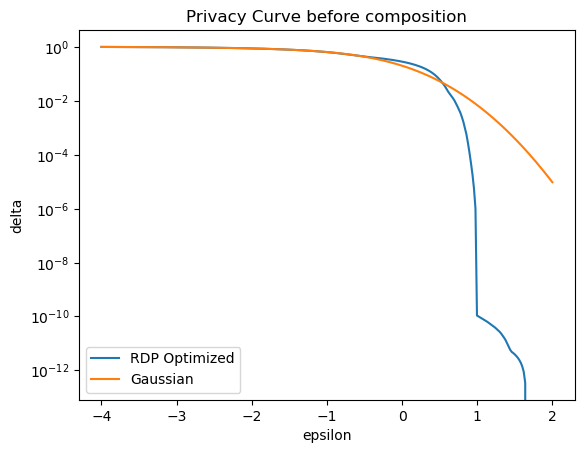

In [61]:
plt.plot(epsy, deltas_pld, label = 'RDP Optimized')
plt.plot(epsy, deltas_gauss, label = 'Gaussian')
plt.yscale('log');
plt.title('Privacy Curve before composition');
plt.xlabel('epsilon'); plt.ylabel('delta'); plt.legend();

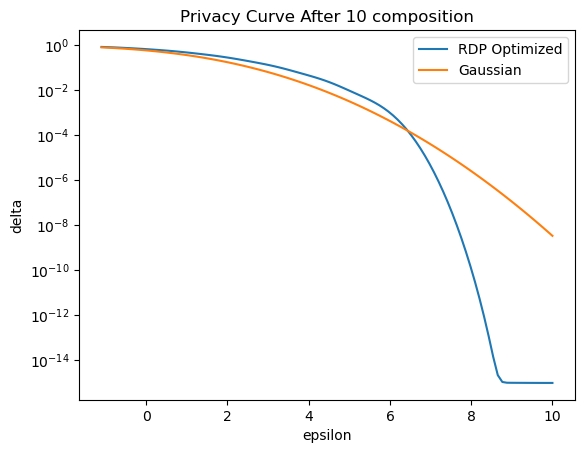

In [60]:
plt.plot(epsy_composed, deltas_pld_composed, label = 'RDP Optimized')
plt.plot(epsy_composed, deltas_gauss_composed, label = 'Gaussian')
plt.yscale('log');
plt.title(f'Privacy Curve After {compositions} composition');
plt.xlabel('epsilon'); plt.ylabel('delta'); plt.legend();

# (IGNORE) Test PLD Accounting 

In [21]:
compositions = 10
sigma_squared, _ = check_constraints(optimal_noise,N,k,r,q)
sigma = np.sqrt(float(sigma_squared))


s = 11
s1 = 10
epsy = np.linspace(-4,2,300)

deltas_true = DiscreteRDPPrivacyLoss(p_vec = optimal_noise, k = k, N = N, r = r, sensitivity = s).get_delta_for_epsilon(epsy)
pld = from_discrete_RDP_mechanism(p_vec = optimal_noise, k = k, N = N, r = r, sensitivity = s)
deltas_pld = pld.get_delta_for_epsilon(epsy)

deltas_true1 = DiscreteRDPPrivacyLoss(p_vec = optimal_noise, k = k, N = N, r = r, sensitivity = s1).get_delta_for_epsilon(epsy)
pld1 = from_discrete_RDP_mechanism(p_vec = optimal_noise, k = k, N = N, r = r, sensitivity = s1)
deltas_pld1 = pld1.get_delta_for_epsilon(epsy)

epsilons = np.linspace(-1.1, 10, 100)
composed_pld = pld.self_compose(compositions)
deltas_pld_composed = composed_pld.get_delta_for_epsilon(epsilons)

composed_pld1 = pld1.self_compose(compositions)
deltas_pld_composed1 = composed_pld1.get_delta_for_epsilon(epsilons)


xlow, xhigh = (-594, 583)
epslow, epshigh = (-1.084706455318034, 1.084706455318034)
xlow, xhigh = (-593, 583)
epslow, epshigh = (-1.0493573124594273, 1.049357312459427)


In [19]:
np.where(deltas_true1 > deltas_true)[0]

array([], dtype=int64)

In [20]:
np.where(deltas_pld1 > deltas_pld)[0]

array([254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279,
       280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292,
       293, 294, 295, 296, 297, 298, 299])

In [15]:
deltas_pld[254], deltas_pld1[254]

(1.1744357825985102e-11, 1.2033208381503019e-11)

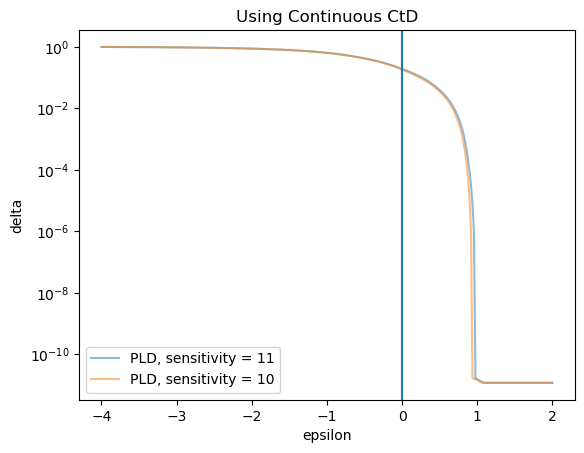

In [27]:
# CONTINUOUS

# plt.plot(epsy, deltas_true, alpha = 0.5, label = f'True, sensitivity = {s}')
plt.plot(epsy, deltas_pld, alpha = 0.5, label = f'PLD, sensitivity = {s}')

# plt.plot(epsy, deltas_true1, alpha = 0.5, label = f'True, sensitivity = {s1}')
plt.plot(epsy, deltas_pld1, alpha = 0.5, label = f'PLD, sensitivity = {s1}')
plt.axvline(deltas_pld[254])

plt.yscale('log');
plt.title('Privacy Curve');
plt.legend(loc = 'lower left');
plt.xlabel('epsilon'); plt.ylabel('delta');
plt.title('Using Continuous CtD');
# plt.xlim([-1.1,0]);
# plt.ylim([1e-1, 1]);

# (IGNORE) Old Test

In [28]:
compositions = 10
sigma_squared, _ = check_constraints(optimal_noise,N,k,r,q)
sigma = np.sqrt(float(sigma_squared))

# ss = [1,2,3,10,20,40,60,80,100]
ss = [1,2,3,10,20]
epsy = np.linspace(-1,4,300)
epsilons = np.linspace(-1.1, 10, 100)
deltass = []
inny_deltass = []
for s in ss: 
    pld = from_discrete_RDP_mechanism(p_vec = optimal_noise, k = k, N = N, r = r, sensitivity = s)
    inny_deltas = pld.get_delta_for_epsilon(epsy)
    inny_deltass.append(inny_deltas)
    composed_pld = pld.self_compose(compositions)
    deltas = composed_pld.get_delta_for_epsilon(epsilons)
    deltass.append(deltas)
    
pld_gaussian = from_gaussian_mechanism(standard_deviation = sigma)
composed_gaussian = pld_gaussian.self_compose(compositions)

one_deltas_gauss = pld_gaussian.get_delta_for_epsilon(epsy)

deltas_gauss = composed_gaussian.get_delta_for_epsilon(epsilons)

xlow, xhigh = (-584, 583)
epslow, epshigh = (-0.7311852412080369, 0.7311852412080369)
xlow, xhigh = (-585, 583)
epslow, epshigh = (-0.7665388961527457, 0.7665388961527458)
xlow, xhigh = (-586, 583)
epslow, epshigh = (-0.8018923661690529, 0.8018923661690528)
xlow, xhigh = (-593, 583)
epslow, epshigh = (-1.0493573124594273, 1.049357312459427)
xlow, xhigh = (-603, 583)
epslow, epshigh = (-1.6557767716167966, 1.6557767716167966)


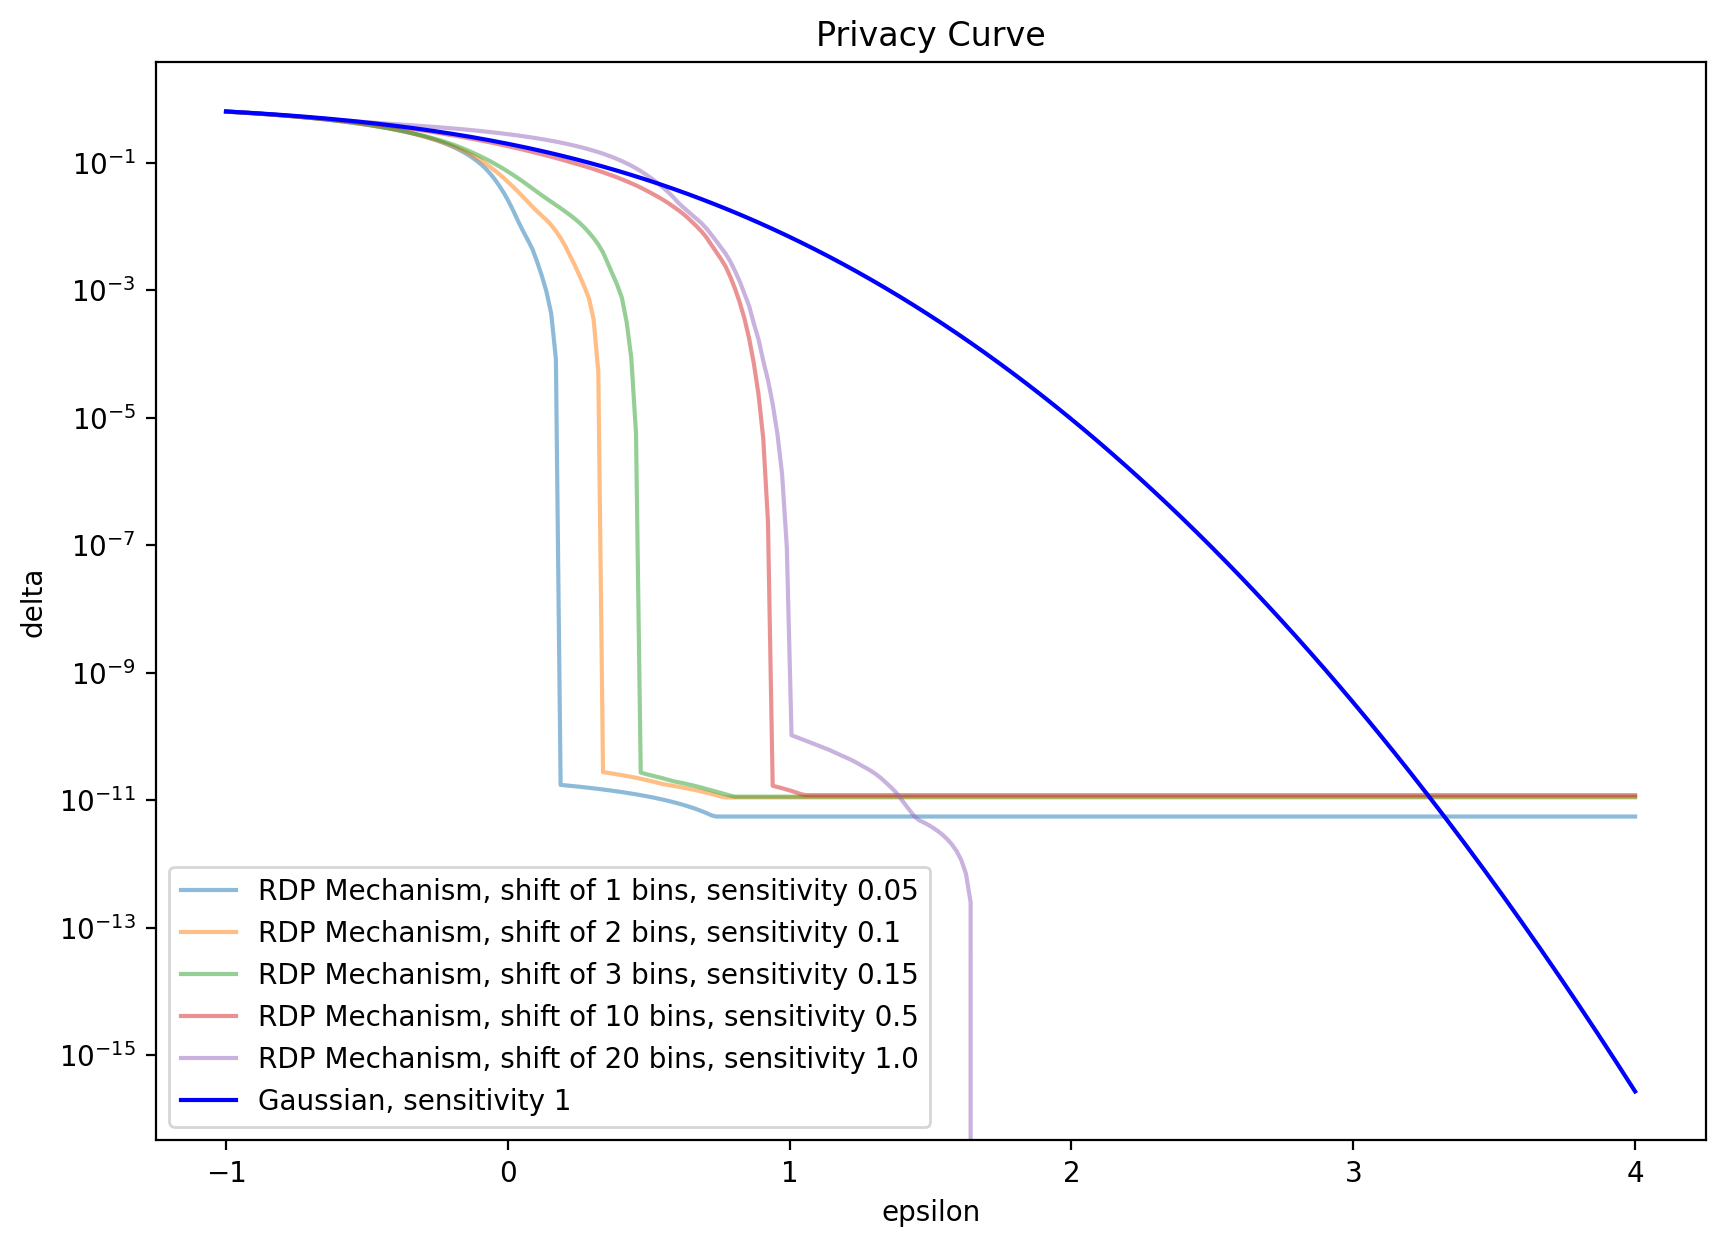

In [30]:
plt.figure( figsize = (10,7), dpi =200) 

for s, indeltas in zip(ss, inny_deltass):
    
    plt.plot(epsy, indeltas, alpha = 0.5, label = f'RDP Mechanism, shift of {s} bins, sensitivity {s / k:0.4}')
    # plt.scatter(epsy, indeltas, alpha = 0.5, s = 2, label = f'RDP Mechanism, sensitivity {s}')
# plt.plot(epsy, init_deltas)
# plt.plot(epsy, two_deltas, label = 'Discrete RDP Mechanism, s = 2')
plt.plot(epsy, one_deltas_gauss, c = 'blue', alpha = 1, label = 'Gaussian, sensitivity 1')
# plt.ylim(0,1);
plt.yscale('log');
plt.title('Privacy Curve');
plt.legend(loc = 'lower left');
plt.xlabel('epsilon'); plt.ylabel('delta');

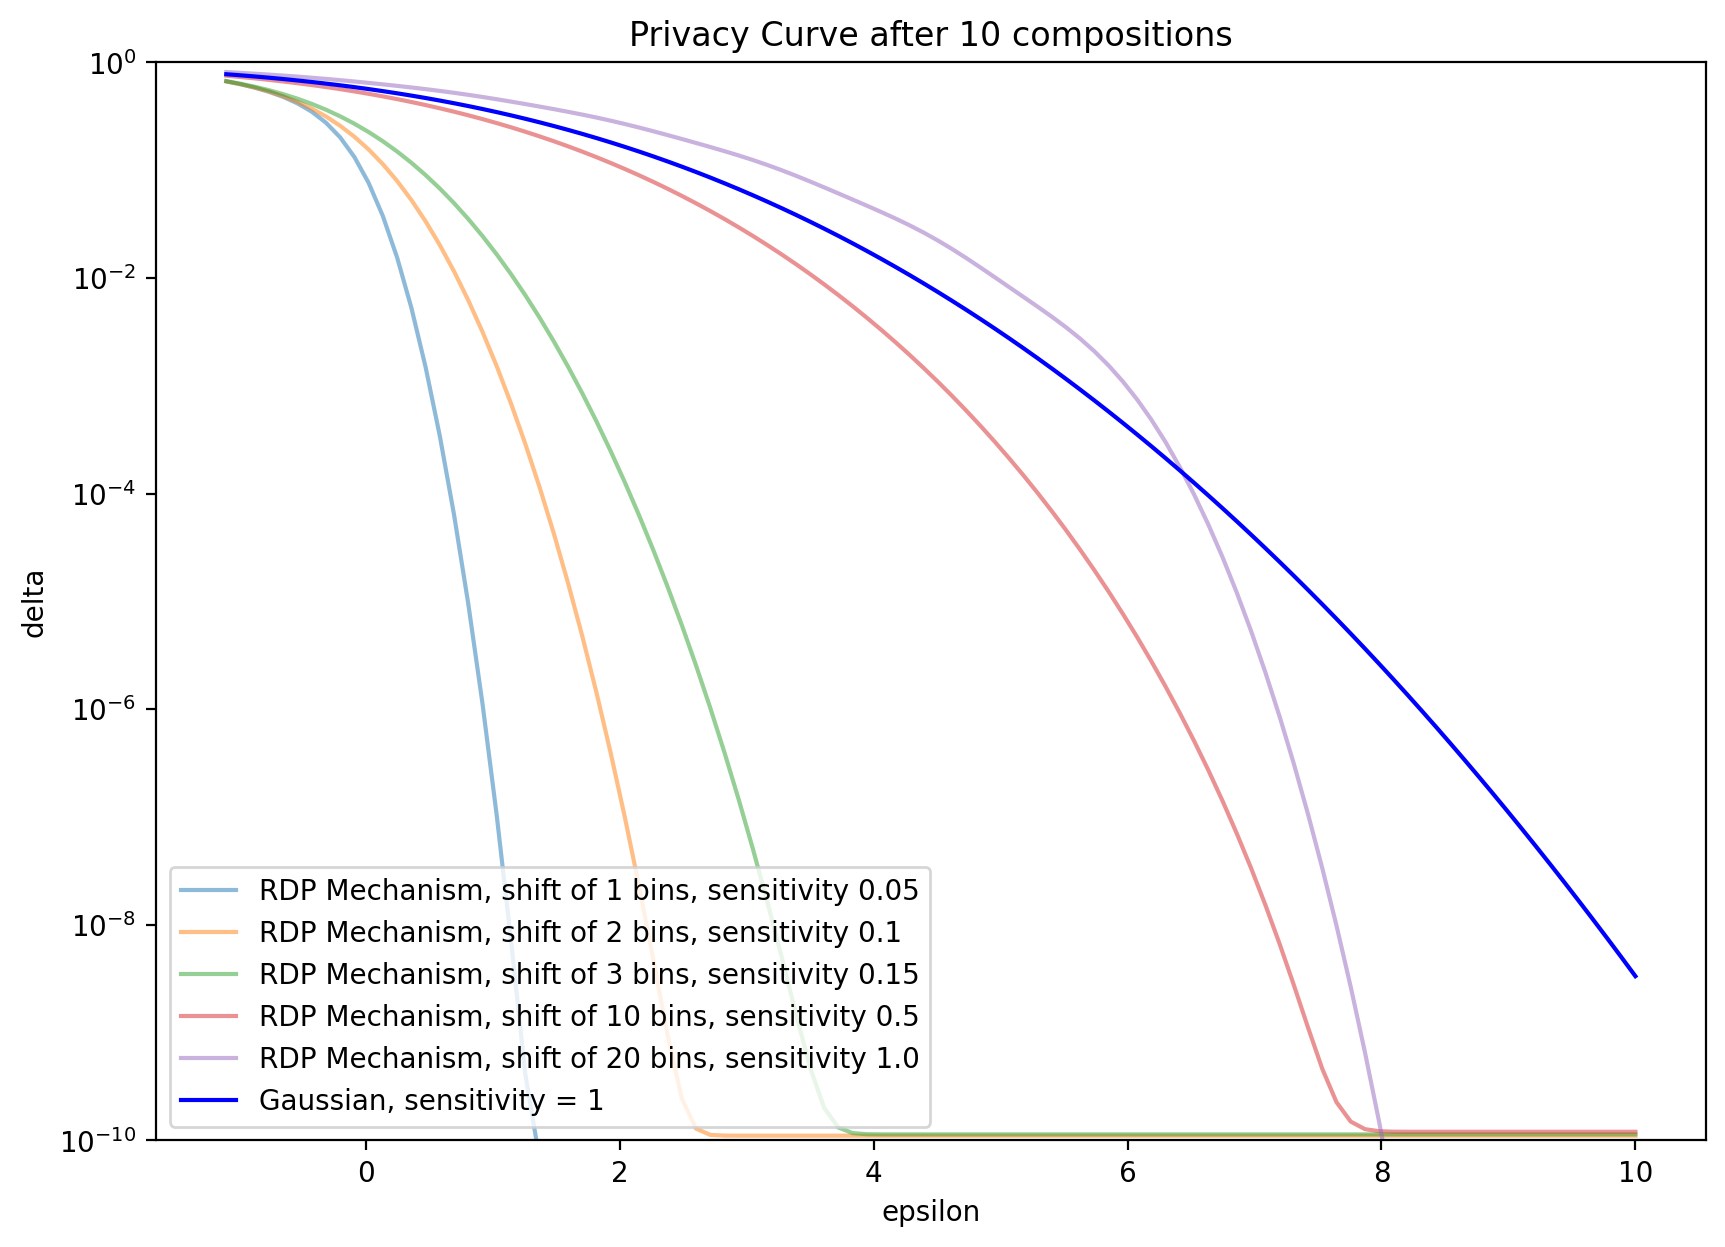

In [31]:
plt.figure( figsize = (10,7), dpi =200) 

for s, bdeltas in zip(ss, deltass):
    plt.plot(epsilons, bdeltas, alpha = 0.5, label = f'RDP Mechanism, shift of {s} bins, sensitivity {s / k:0.4}')
    # plt.scatter(epsilons, bdeltas, alpha = 0.5, label = f'RDP Mechanism, sensitivity {s}')
# plt.plot(epsilons, deltas, label = 'Discrete RDP Mechanism')
plt.plot(epsilons, deltas_gauss, c = 'blue', label =  'Gaussian, sensitivity = 1')
plt.yscale('log');
plt.ylim(1e-10,1)
plt.title(f'Privacy Curve after {compositions} compositions');
plt.legend(loc = 'lower left')
# plt.xlim(-1,1); plt.ylim(1e-1, 1)
plt.xlabel('epsilon'); plt.ylabel('delta');